In [2]:
import copy as cp
import random
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
plt.style.use("seaborn-colorblind")
import tensorflow as tf

In [53]:
class Env:
    
    S1_1_mean = [-0.7, 0.4]
    S1_2_mean = [0.6, 0.6]
    S2_mean = [0.2, -0.5]
    S3_mean = [-0.7, -0.6]
    VAR = 0.02
    COV = [[VAR, 0], [0, VAR]]
    
    def __init__(self):
        
        self.state = 1
        
    def step(self):
        
        self.state += 1
        
        if self.state == 3:
            return cp.deepcopy(self.get_observation()), 1, True
        else:
            return cp.deepcopy(self.get_observation()), 0, False
        
    def reset(self):
        
        self.state = 1

    def get_observation(self):
        
        if self.state == 1:
            mean = random.choice([self.S1_1_mean, self.S1_2_mean])
        elif self.state == 2:
            mean = self.S2_mean
        elif self.state == 3:
            mean = self.S3_mean
        else:
            raise ValueError("Invalid state.")
            
        return np.random.multivariate_normal(mean, self.COV, size=1)[0]
        
    def plot(self):
        
        s1_1 = np.random.multivariate_normal(self.S1_1_mean, self.COV, size=100)
        s1_2 = np.random.multivariate_normal(self.S1_2_mean, self.COV, size=100)
        s1 = np.concatenate([s1_1, s1_2], axis=0)
        
        s2 = np.random.multivariate_normal(self.S2_mean, self.COV, size=100)
        s3 = np.random.multivariate_normal(self.S3_mean, self.COV, size=100)
        
        plt.scatter(s1[:, 0], s1[:, 1], label="s1")
        plt.scatter(s2[:, 0], s2[:, 1], label="s2")
        plt.scatter(s3[:, 0], s3[:, 1], label="s3")
        plt.xlim([-1, 1])
        plt.ylim([-1, 1])
        plt.legend()
        plt.show()

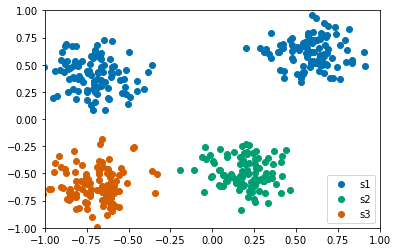

In [54]:
env = Env()
env.plot()

In [55]:
num_steps = 1000
states = []
rewards = []
next_states = []
dones = []
states_real = []
next_states_real = []

env = Env()

for i in range(num_steps):
    state = env.get_observation()
    real_state = cp.deepcopy(env.state)
    next_state, reward, done = env.step()
    real_next_state = cp.deepcopy(env.state)
    
    states.append(state)
    states_real.append(real_state)
    rewards.append(reward)
    next_states.append(next_state)
    next_states_real.append(real_next_state)
    dones.append(done)
    
    if done:
        env.reset()
    
states = np.array(states, dtype=np.float32)
rewards = np.array(rewards, dtype=np.float32)
next_states = np.array(next_states, dtype=np.float32)
dones = np.array(dones, dtype=np.float32)

In [282]:
tf.reset_default_graph()

learning_rate = 0.01
z_size = 3
norm = 0.5
lambda_1 = 0.5

state_pl = tf.placeholder(tf.float32, shape=(None, 2), name="state_pl")
next_state_pl = tf.placeholder(tf.float32, shape=(None, 2), name="next_state_pl")
reward_pl = tf.placeholder(tf.float32, shape=(None,), name="reward_pl")
done_pl = tf.placeholder(tf.float32, shape=(None,), name="done_pl")
target_pl = tf.placeholder(tf.float32, shape=(None, z_size), name="target_pl")

z_t = tf.layers.dense(state_pl, 20, activation=tf.nn.relu)
z_t = tf.layers.dense(z_t, 20, activation=tf.nn.relu)
z_t = tf.layers.dense(z_t, z_size, activation=tf.nn.softmax)
z_bar_t = tf.layers.dense(z_t, z_size, activation=None)
r_bar_t = tf.layers.dense(z_t, 1, activation=None)[:, 0]

norm_t = tf.pow(tf.reduce_sum(tf.pow(tf.abs(z_t), norm), axis=1), 1 / norm)
norm_loss_t = tf.reduce_mean(norm_t)
                      
loss_transition_t = (1.0 - done_pl) * tf.reduce_mean((z_bar_t - target_pl) ** 2, axis=1)
loss_reward_t = (r_bar_t - reward_pl) ** 2
    
loss_t = loss_transition_t + loss_reward_t
loss_t = tf.reduce_mean(loss_t) + lambda_1 * norm_loss_t
train_step = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss_t)

<IPython.core.display.Javascript object>


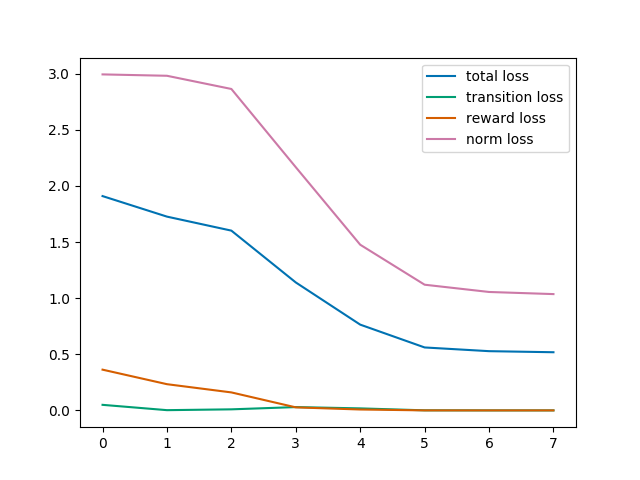

In [283]:
steps = 250
batch_size = 32
epoch_size = len(states) // batch_size

losses = []
transition_losses = []
reward_losses = []
norm_losses = []

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    epoch_losses = []
    epoch_transition_losses = []
    epoch_reward_losses = []
    epoch_norm_losses = []
    
    for i in range(steps):

        epoch_idx = i % epoch_size
        batch_slice = np.index_exp[epoch_idx * batch_size : (epoch_idx + 1) * batch_size]
        
        z = sess.run(z_t, feed_dict={
            state_pl: next_states[batch_slice]
        })
        
        _, loss, loss_transition, loss_reward, norm_loss = sess.run(
            [train_step, loss_t, loss_transition_t, loss_reward_t, norm_loss_t]
            , feed_dict={
            
            state_pl: states[batch_slice],
            reward_pl: rewards[batch_slice],
            done_pl: dones[batch_slice],
            target_pl: z
        })
        
        epoch_losses.append(loss)
        epoch_transition_losses.append(np.mean(loss_transition))
        epoch_reward_losses.append(np.mean(loss_reward))
        epoch_norm_losses.append(norm_loss)
        
        if epoch_idx == 0 and i > 0:
            losses.append(np.mean(epoch_losses))
            transition_losses.append(np.mean(epoch_transition_losses))
            reward_losses.append(np.mean(epoch_reward_losses))
            norm_losses.append(np.mean(epoch_norm_losses))
            epoch_losses = []
            epoch_transition_losses = []
            epoch_reward_losses = []
            epoch_norm_losses = []
            
    zs = sess.run(z_t, feed_dict={
        state_pl: states
    })
    nzs = sess.run(z_t, feed_dict={
        state_pl: next_states
    })
          
%matplotlib notebook

plt.plot(losses, label="total loss")
plt.plot(transition_losses, label="transition loss")
plt.plot(reward_losses, label="reward loss")
plt.plot(norm_losses, label="norm loss")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


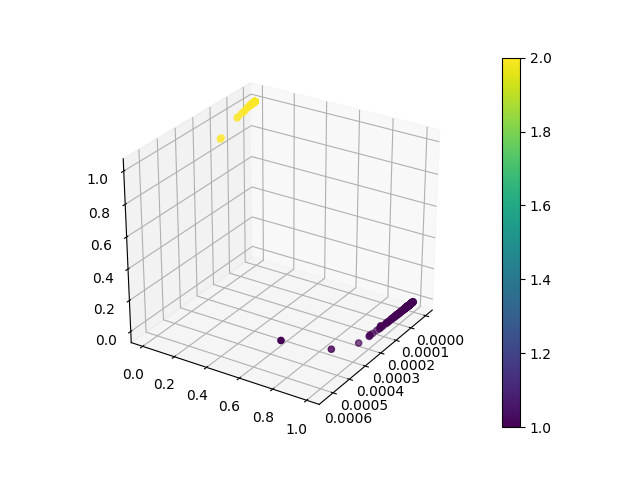

In [285]:
%matplotlib notebook


#tmp_zs = np.concatenate([zs, nzs], axis=0)
#tmp_real = np.concatenate([states_real, next_states_real], axis=0)
tmp_zs = zs
tmp_real = states_real

if z_size == 1:
    plt.scatter(tmp_zs[:, 0], np.zeros_like(tmp_zs[:, 0]), c=tmp_real)
    plt.colorbar()
    plt.show()
elif z_size == 2:
    plt.scatter(tmp_zs[:, 0], tmp_zs[:, 1], c=tmp_real)
    plt.colorbar()
    plt.show()
elif z_size == 3:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(tmp_zs[:, 0], tmp_zs[:, 1], tmp_zs[:, 2], c=tmp_real)
    fig.colorbar(sc)
    plt.show()
else:
    raise ValueError("Cannot plot 4D or higher.")